In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import torch
import tqdm

sys.path.append(os.path.dirname(os.getcwd())) 
from source.model_output import SEIRModelOutput, SEIRParams
from source.SEIR_network import SEIRNetworkModel
from source.autoencoder import AESurrogateModel
from source.forecast import SEIRForecaster
import source.plots as plots

from sklearn.metrics import r2_score

# to account for updates when files change
%load_ext autoreload
%autoreload 2

In [3]:
ae_model = AESurrogateModel(population=10**5)

beta = 0.5 # transmission rate
gamma = 0.3 # latent period rate
delta = 0.2 # recovery rate
init_inf_frac = 1e-4 # fraction of initially infected

alpha = 0.95
beta = 0.1

initial_params = SEIRParams(0.5, 0.5, gamma, delta, init_inf_frac, tmax=150)
observed_incidence = np.loadtxt('../data/incidence_synthetic_curve.csv'
                               )[:100]
simulation_incidence = ae_model.simulate(alpha, beta, gamma, delta, init_inf_frac)

In [4]:
observed_data = pd.read_csv('../data/incidence_synthetic_curve.csv'
                           ).iloc[:100]
observed_data.columns=['incidence']
peak_index = observed_data.incidence.argmax()
observed_data.iloc[:peak_index - 14].shape

(13, 1)

In [5]:
observed_data = pd.read_csv('../data/incidence_synthetic_curve.csv'
                           ).iloc[:100]
observed_data.columns=['incidence']
observed_incidence = observed_data.incidence.values
observed_incidence

array([  77,  133,  209,  248,  316,  362,  407,  457,  543,  662,  746,
        905, 1008, 1162, 1305, 1456, 1597, 1838, 1990, 2151, 2341, 2509,
       2590, 2879, 2893, 2862, 2873, 2928, 2898, 2743, 2731, 2632, 2440,
       2351, 2077, 1873, 1787, 1634, 1545, 1369, 1265, 1121,  966,  902,
        730,  772,  604,  615,  494,  463,  400,  354,  296,  283,  240,
        231,  178,  186,  147,  123,  134,   84,   89,  101,   60,   52,
         55,   48,   32,   30,   42,   22,   19,   14,   14,   15,   13,
          6,    6,    7,    5,    5,    7,    3,    6,    5,    3,    5,
          0,    2,    2,    0,    0,    1,    3,    1,    2,    1,    0,
          1])

In [6]:

peak_index = observed_incidence.argmax()
onset_period = peak_index - 14 
peak_period = peak_index - 7
end_period = peak_index + 7
peak_index, onset_period, peak_period, end_period

(np.int64(27), np.int64(13), np.int64(20), np.int64(34))

In [7]:
%%time

peak_index = observed_incidence.argmax()

onset_period = peak_index - 14
peak_period = peak_index - 7
end_period = peak_index + 7

for period in [onset_period, peak_period, end_period]:
    forecaster = SEIRForecaster(initial_params=initial_params)

    idata_onset = forecaster.calibrate(ae_model, 
                                             observed_incidence[:100],
                                             period,
                                             epsilon=500)

    idata_onset.sample_stats['beta'] = idata_onset.sample_stats['beta'].astype(str)
    idata_onset.to_netcdf(f"ba_surr_a{alpha}_b{beta}_from_{period}n.nc")


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

CPU times: total: 10.9 s
Wall time: 2min 7s


In [10]:
d = pd.read_csv(r'../data/data_ba_100000.csv', index_col=0
                ).reset_index(drop=True).iloc[::10]
d

,beta,gamma,delta,init_inf_frac,init_rec_frac,0,1,2,3,4,...,140,141,142,143,144,145,146,147,148,149
0,0.10,0.3,0.2,0.0001,0.20,0.0,7.0,21.0,23.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.10,0.3,0.2,0.0001,0.21,0.0,7.0,24.0,30.0,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.10,0.3,0.2,0.0001,0.22,0.0,18.0,19.0,26.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.10,0.3,0.2,0.0001,0.23,0.0,9.0,28.0,37.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.10,0.3,0.2,0.0001,0.24,0.0,12.0,20.0,46.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71950,0.99,0.3,0.2,0.0001,0.95,0.0,565.0,1451.0,2852.0,5217.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71960,0.99,0.3,0.2,0.0001,0.96,0.0,643.0,1808.0,3580.0,6547.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71970,0.99,0.3,0.2,0.0001,0.97,0.0,612.0,1707.0,3589.0,6842.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71980,0.99,0.3,0.2,0.0001,0.98,0.0,697.0,2183.0,4896.0,8930.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


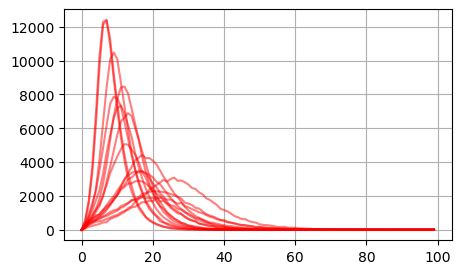

In [11]:
plt.subplots(figsize=(5,3))

if 'init_rec_frac' in d.columns:
    d.rename(columns={'init_rec_frac':'alpha'}, inplace=True)
d.drop(columns=['gamma','delta','init_inf_frac'], inplace=True)
d.columns = ['beta','alpha', *np.arange(150)]

d.alpha = d.alpha.round(2)
d.beta = d.beta.round(2)


for a,b in zip([0.95, 0.97,0.85, 0.97, 0.88,
               0.75,.65,.74, .65, .97, .85, .74,   
                .98, .85, .7, .61],
               [0.1, 0.5,0.95,0.95,0.5,
               0.95, .95,.5, .49, .3,.3,.3,     
                .75, .75, .75, .75]):
    observed_data = d[(d.beta==b)&(d.alpha==a)].iloc[0,2:102]
    observed_data.columns=['incidence']
    plt.plot(observed_data, color='red', alpha=.5)

plt.grid()

In [12]:
for a,b in tqdm.tqdm(zip([0.95, 0.97,0.85, 0.97, 0.88,
               0.75,.65,.74, .65, .97, .85, .74,   
                .98, .85, .7, .61],
               [0.1, 0.5,0.95,0.95,0.5,
               0.95, .95,.5, .49, .3,.3,.3,     
                .75, .75, .75, .75])):
    observed_incidence = d[(d.beta==b)&(d.alpha==a)
                          ].iloc[0,2:102].values
    
    forecaster = SEIRForecaster(initial_params=initial_params)

    idata_onset = forecaster.calibrate(ae_model, 
                                             observed_incidence[:100],
                                             len(observed_incidence),
                                             epsilon=2000)

    idata_onset.sample_stats['beta'] = idata_onset.sample_stats['beta'].astype(str)
    idata_onset.to_netcdf(f"ba_surr_a{a}_b{b}_full_n.nc")

0it [00:00, ?it/s]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


1it [00:34, 34.16s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


2it [01:05, 32.57s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


3it [01:35, 31.34s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


4it [02:01, 29.33s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


5it [02:33, 30.25s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


6it [02:56, 27.87s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


7it [03:19, 26.18s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


8it [03:43, 25.60s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


9it [04:09, 25.59s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


10it [04:42, 27.85s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


11it [05:13, 28.91s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


12it [05:36, 27.17s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


13it [06:03, 27.07s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


14it [06:33, 27.83s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


15it [06:55, 26.03s/it]Initializing SMC sampler...
Sampling 4 chains in 4 jobs


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\arviz\data\base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [sim]


D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

full calibr


16it [07:19, 27.45s/it]


In [13]:
1

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\IPython\extensions\autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Programs\Anaconda\envs\pymc_env\Lib\site-packages\IPython\extensions\autoreload.py", line 483, in superreload
    module = reload(module)
  File "D:\Programs\Anaconda\envs\pymc_env\Lib\importlib\__init__.py", line 128, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


1

In [ ]:
for period in [onset_period, peak_period, end_period]:
    forecaster = SEIRForecaster(initial_params=initial_params)

    idata_onset = forecaster_onset.calibrate(ae_model, 
                                             observed_incidence[:100],
                                             period,
                                             epsilon=500)

    idata_onset.sample_stats['beta'] = idata_onset.sample_stats['beta'].astype(str)
    idata_onset.to_netcdf(f"ba_surr_a{alpha}_b{beta}_full.nc")

In [33]:
idata_onset

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

KeyError: 'var names: "[\'beta\'] are not present" in dataset'

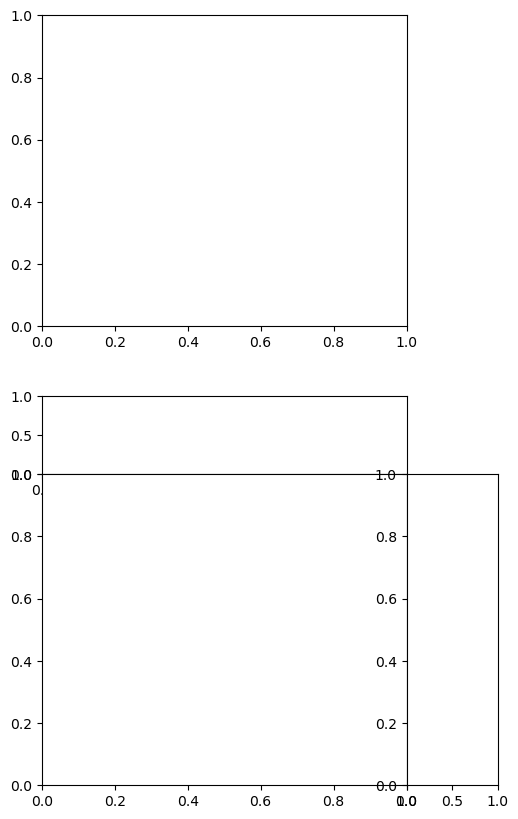

In [16]:
true_alpha = 0.95
true_beta = 0.1
fig = plots.plot_calib_subplots([idata_onset, idata_onset, idata_onset], 
              [observed_incidence[:end] for end in [onset_period, 
                                                    onset_period, 
                                                    onset_period]], 
              true_params_dict={'alpha': true_alpha, 
                                'beta': true_beta},
              full_data=observed_incidence
                               )
#fig.savefig('../figures/ae_ba_network_hdr_subplots.pdf', bbox_inches='tight')
#fig.savefig('../figures/ae_ba_network_hdr_abc_subplots.png', bbox_inches='tight', dpi=600)


In [6]:
fig = create_plots_grid_forecast(array_of_params_dict=[params_dict_onset, params_dict_peak, params_dict_end], 
                           array_of_observed=[observed_incidence[:onset_period], 
                                                       observed_incidence[:peak_period],
                                                       observed_incidence[:end_period]],
                           full_data=observed_incidence)
#fig.savefig('../figures/ae_ba_network_forercast.pdf', bbox_inches='tight')
#fig.savefig('../figures/ae_ba_network_forercast.png', dpi=600, bbox_inches='tight')

NameError: name 'create_plots_grid_forecast' is not defined